### Descripcion del Proyecto Orientado

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.

- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir si es probable que un nuevo cliente reciba un beneficio de seguro. ¿Puede un modelo de predicción entrenado funcionar mejor que un modelo dummy no entrenado? - ¿Puede funcionar peor? Explica tu respuesta.
- Tarea 3: predecir la cantidad de beneficios de seguro que probablemente recibirá un nuevo cliente utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin romper el modelo de la tarea anterior.

Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento de datos u ofuscación de datos. Pero los datos deben protegerse de tal manera que la calidad de los modelos de machine learning no se vea afectada. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.

Descripción de datos
El dataset se almacena en el archivo /datasets/insurance_us.csv.

- Características: sexo, edad, salario y número de familiares de la persona asegurada.
- Objetivo: número de beneficios de seguro recibidos por una persona asegurada en los últimos cinco años.

In [1]:
# Importación de bibliotecas estándar
import numpy as np
import pandas as pd

# Importación de bibliotecas de visualización
import seaborn as sns
import matplotlib.pyplot as plt

# Importación de bibliotecas para machine learning y modelos
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import Ridge

# Importación de bibliotecas adicionales para análisis
from scipy.spatial import distance

#### Carga los datos.


In [2]:
raw_insurance = pd.read_csv('../datasets/insurance_us.csv')
raw_insurance

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


In [3]:
# Verifica que los datos no tengan problemas: no faltan datos, no hay valores extremos, etc.
raw_insurance.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              5000 non-null   int64  
 1   Age                 5000 non-null   float64
 2   Salary              5000 non-null   float64
 3   Family members      5000 non-null   int64  
 4   Insurance benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [4]:
# Revisamos si tenemos valores duplicados
raw_insurance.duplicated().value_counts()

False    4847
True      153
Name: count, dtype: int64

In [5]:
# Eliminamos los valores duplicados
raw_insurance.drop_duplicates(inplace=True)

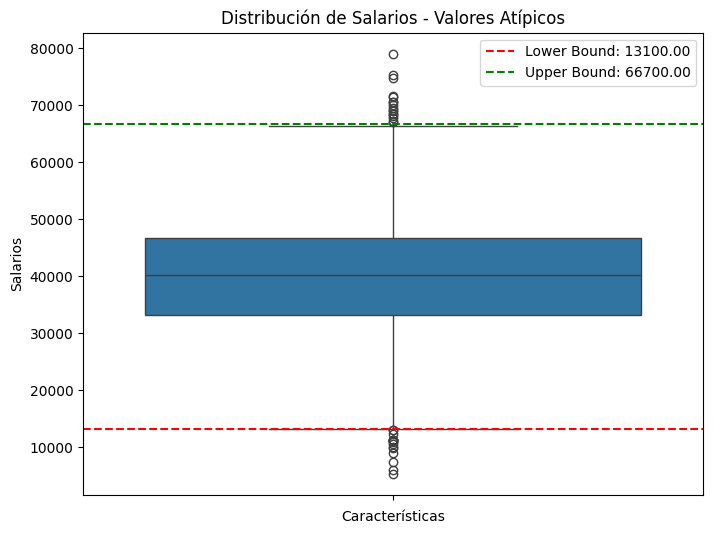

In [6]:
# Valores Atípicos (Outliers) en el salario

# Calculamos los percentiles y el IQR para detectar outliers
Q1 = raw_insurance['Salary'].quantile(0.25)
Q3 = raw_insurance['Salary'].quantile(0.75)
IQR = Q3 - Q1

# Definimos los límites superior e inferior para los valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Creamos un boxplot
plt.figure(figsize=(8,6))
sns.boxplot(data=raw_insurance['Salary'])

# Añadimos líneas para delimitar los valores atípicos
plt.axhline(y=lower_bound, color='r', linestyle='--', label=f'Lower Bound: {lower_bound:.2f}')
plt.axhline(y=upper_bound, color='g', linestyle='--', label=f'Upper Bound: {upper_bound:.2f}')

# Añadimos título y etiquetas
plt.title('Distribución de Salarios - Valores Atípicos')
plt.xlabel('Características')
plt.ylabel('Salarios')

# Mostramos el gráfico
plt.legend()
plt.show()

#### Comentarios:

- Solo tenemos verdadera variabilidad en los salarios.
- Tenemos valores atipicos, pero considero que es importante mantenerlos para el objetivo del proyecto.

#### Daremos solucion a cada tarea

In [7]:
df_insurance = raw_insurance.reset_index(drop=True)
df_insurance

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4842,0,28.0,35700.0,2,0
4843,0,34.0,52400.0,1,0
4844,0,20.0,33900.0,2,0
4845,1,22.0,32700.0,3,0


#### Tarea 1: Encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.

In [8]:
# Primero escalaremos los datos

columns_name = df_insurance.columns

scaler = StandardScaler()

df_scaled = scaler.fit_transform(df_insurance)

# Datos escalados
df_scaled = pd.DataFrame(df_scaled, columns=columns_name)

df_scaled

,Gender,Age,Salary,Family members,Insurance benefits
0,1.00310,1.175436,0.973151,-0.185176,-0.324725
1,-0.99691,1.764564,-0.190115,-0.185176,1.807989
2,-0.99691,-0.238471,-1.894901,-1.095466,-0.324725
3,-0.99691,-1.181076,0.180927,0.725115,-0.324725
4,1.00310,-0.356297,-1.383465,-1.095466,-0.324725
...,...,...,...,...,...
4842,-0.99691,-0.356297,-0.420762,0.725115,-0.324725
4843,-0.99691,0.350657,1.253939,-0.185176,-0.324725
4844,-0.99691,-1.298901,-0.601269,0.725115,-0.324725
4845,1.00310,-1.063250,-0.721607,1.635405,-0.324725


In [9]:
def find_similar_customers(df_scaled, client_index, top_n=5, weight=2): # le aumentamos el peso con weight
    
    client_vector = df_scaled.iloc[client_index].values
    
    #Le daremos mas peso a la columna Insurance Benefits
    df_scaled['Insurance benefits'] = df_scaled['Insurance benefits'] * weight 
    
    #Usaremos distancia euclideana entre el cliente 
    distances = df_scaled.apply(lambda row: distance.euclidean(client_vector, row.values), axis=1)
    
    closest_indices = distances.sort_values().index[1:top_n+1] # Excluimos el cliente_index del cliente escogido
    
    return closest_indices, distances[closest_indices]

In [10]:
# Cliente similares segun distancia euclidiana.
client_index = 0

similar_customers, distances_to_similar_customers = find_similar_customers(df_scaled, client_index)

print("Distancias correspondientes:")
print(distances_to_similar_customers , '\n')

print("Clientes de índice: ", client_index )
print(df_insurance.loc[client_index], '\n')

print("Clientes similares al cliente en el índice 0:")
print(df_insurance.loc[similar_customers])

Distancias correspondientes:
2632    0.328574
133     0.352501
1550    0.399443
3541    0.409881
2072    0.410243
dtype: float64 

Clientes de índice:  0
Gender                    1.0
Age                      41.0
Salary                49600.0
Family members            1.0
Insurance benefits        0.0
Name: 0, dtype: float64 

Clientes similares al cliente en el índice 0:
      Gender   Age   Salary  Family members  Insurance benefits
2632       1  41.0  50100.0               1                   0
133        1  40.0  50300.0               1                   0
1550       1  40.0  47600.0               1                   0
3541       1  40.0  47400.0               1                   0
2072       1  41.0  47100.0               1                   0


#### Tarea 2: Predecir si es probable que un nuevo cliente reciba un beneficio de seguro. ¿Puede un modelo de predicción entrenado funcionar mejor que un modelo dummy no entrenado? ¿Puede funcionar peor?

In [11]:
# Revisamos la frecuecia de los registros.
df_scaled['Insurance benefits'].value_counts()

Insurance benefits
-0.649451     4284
 3.615979      423
 7.881408      114
 12.146837      18
 16.412266       7
 20.677695       1
Name: count, dtype: int64

In [12]:
 # Convertimos a 1 si es mayor a 0
df_scaled['Insurance benefits_bin'] = (df_scaled['Insurance benefits'] > 0).astype(int)
df_scaled['Insurance benefits_bin'].value_counts() #Con esto vemos un fuerte desbalance

Insurance benefits_bin
0    4284
1     563
Name: count, dtype: int64

In [13]:
# Datos de entrenamiento y datos de validacion
features = df_scaled.drop(['Insurance benefits', 'Insurance benefits_bin'], axis=1)
target = df_scaled['Insurance benefits_bin']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=42) # estan ya escalados

In [14]:
# Balanceamos los datos utilizando 'resample' para manejar el desbalance de clases

# Concatenamos las características y el objetivo en un solo DataFrame
data_train = pd.concat([features_train, target_train], axis=1)

# Separamos las clases mayoritaria y minoritaria
major_class = data_train[data_train['Insurance benefits_bin'] == 0]  # Clase mayoritaria (con valor 0)
minor_class = data_train[data_train['Insurance benefits_bin'] == 1]  # Clase minoritaria (con valor 1)

# Realizamos el resampling (sobremuestreo) de la clase minoritaria
minor_class_resampled = resample(
    minor_class, 
    replace=True,  # Permitir reemplazo para generar muestras adicionales
    n_samples=len(major_class),  # Redimensionamos la clase minoritaria para igualar la clase mayoritaria
    random_state=42  # Fijamos la semilla para reproducibilidad
)

# Concatenamos las clases mayoritaria y minoritaria balanceadas
data_balanced = pd.concat([major_class, minor_class_resampled])

# Separamos las características y el objetivo en los datos balanceados
features_train_balanced = data_balanced.drop('Insurance benefits_bin', axis=1)  # Características
target_train_balanced = data_balanced['Insurance benefits_bin']  # Objetivo

# Mostramos el balance de las clases en los datos balanceados
print("Distribución de clases después del balanceo:")
print(data_balanced['Insurance benefits_bin'].value_counts())


Distribución de clases después del balanceo:
Insurance benefits_bin
0    3208
1    3208
Name: count, dtype: int64


In [15]:
# Modelo con Dummy, se utiliza un clasificador Dummy que predice la clase más frecuente

# Creamos el modelo DummyClassifier con la estrategia "most_frequent" para predecir siempre la clase más frecuente
dummy_model = DummyClassifier(strategy="most_frequent")  # Clasificador Dummy con la estrategia de clase más frecuente

# Entrenamos el modelo Dummy con los datos balanceados de entrenamiento
dummy_model.fit(features_train_balanced, target_train_balanced)

# Realizamos las predicciones sobre el conjunto de validación
y_pred_dummy = dummy_model.predict(features_valid)

# Evaluamos el desempeño del modelo Dummy utilizando la precisión (accuracy)
dummy_accuracy = accuracy_score(target_valid, y_pred_dummy)

# Mostramos la precisión obtenida por el modelo Dummy
print(f'Precisión del modelo Dummy: {dummy_accuracy:.2f}')

Precisión del modelo Dummy: 0.89


In [16]:
# Modelo de Regresión Logística para predicción y evaluación

# Creamos el modelo de Regresión Logística
model = LogisticRegression()  # Inicializamos el modelo

# Entrenamos el modelo con los datos balanceados de entrenamiento
model.fit(features_train_balanced, target_train_balanced)

# Realizamos predicciones con el modelo entrenado sobre el conjunto de validación
y_pred_model = model.predict(features_valid)

# Evaluamos la precisión del modelo en el conjunto de validación
model_accuracy = accuracy_score(target_valid, y_pred_model)

# Mostramos la precisión del modelo entrenado
print(f'Precisión del modelo entrenado: {model_accuracy:.2f}')

Precisión del modelo entrenado: 0.99


#### Tarea 3: Predecir la cantidad de beneficios de seguro que probablemente recibirá un nuevo cliente utilizando un modelo de regresión lineal.

In [17]:
df_scaled.sample(10)

,Gender,Age,Salary,Family members,Insurance benefits,Insurance benefits_bin
4248,-0.99691,-0.591948,-1.363409,0.725115,-0.649451,0
75,-0.99691,2.000215,0.963123,-1.095466,3.615979,1
2498,1.00310,1.057611,-1.283184,-1.095466,-0.649451,0
2077,-0.99691,0.232831,0.762560,-1.095466,-0.649451,0
824,-0.99691,-1.181076,-0.430791,0.725115,-0.649451,0
757,-0.99691,-0.827599,-0.791804,1.635405,-0.649451,0
64,-0.99691,-0.474122,0.281208,1.635405,-0.649451,0
2740,1.00310,-0.945425,-1.744479,0.725115,-0.649451,0
4643,1.00310,-0.120645,-0.450847,2.545696,-0.649451,0
4607,-0.99691,-1.416727,-0.511016,-0.185176,-0.649451,0


In [18]:
# Preparamos los datos para el modelo: separamos características y target

# Seleccionamos las características (features) y el objetivo (target)
# Tomamos las características del DataFrame original y agregamos la columna 'Salary' ya escalada
features_3 = pd.concat([df_insurance.drop(['Salary'], axis=1), df_scaled['Salary']], axis=1).drop('Insurance benefits', axis=1)

# El objetivo (target) es la columna 'Insurance benefits'
target_3 = df_insurance['Insurance benefits']

# Dividimos los datos en conjuntos de entrenamiento y validación (80% entrenamiento, 20% validación)
features_train_3, features_valid_3, target_train_3, target_valid_3 = train_test_split(
    features_3, target_3, test_size=0.25, random_state=42)  # 75% para entrenamiento, 25% para validación

# Mostramos el tamaño de los conjuntos de entrenamiento y validación para confirmación
print(f"Tamaño del conjunto de entrenamiento: {features_train_3.shape[0]} muestras")
print(f"Tamaño del conjunto de validación: {features_valid_3.shape[0]} muestras")


Tamaño del conjunto de entrenamiento: 3635 muestras
Tamaño del conjunto de validación: 1212 muestras


In [19]:
# Optamos por una regresión lineal para modelar la relación entre las características y el objetivo

# Creamos el modelo de regresión lineal
model_linear = LinearRegression()

# Entrenamos el modelo con los datos de entrenamiento balanceados
model_linear.fit(features_train_3, target_train_3)

# Realizamos las predicciones sobre el conjunto de validación
y_pred_linear = model_linear.predict(features_valid_3)

# Evaluamos el desempeño del modelo utilizando el MSE (Error Cuadrático Medio) y el R2 (coeficiente de determinación)

# Calculamos el MSE, que nos da una medida del error promedio al cuadrar las diferencias entre las predicciones y los valores reales
mse = mean_squared_error(target_valid_3, y_pred_linear)

# Calculamos el R2, que nos indica qué tan bien el modelo se ajusta a los datos (proporción de la varianza explicada)
r2 = r2_score(target_valid_3, y_pred_linear)

# Imprimimos los resultados de la evaluación
print(f'El MSE del modelo de regresión lineal es: {mse:.2f}')
print(f'El R2 del modelo de regresión lineal es: {r2:.2f}')


El MSE del modelo de regresión lineal es: 0.13
El R2 del modelo de regresión lineal es: 0.44


#### Comentarios:

- Como no tenemos buenos resultados para la LinearRegression() asi que probaremos el RandomForestRegression()

In [20]:
# Probamos el modelo de Random Forest para capturar mejor las relaciones no lineales entre las características y el objetivo

# Creamos el modelo de Random Forest Regressor con 170 estimadores y una profundidad máxima de 1 para evitar el sobreajuste
rf_model = RandomForestRegressor(n_estimators=170, max_depth=1, random_state=42)

# Entrenamos el modelo con los datos de entrenamiento balanceados
rf_model.fit(features_train_3, target_train_3)

# Realizamos las predicciones sobre el conjunto de validación
y_pred_rf = rf_model.predict(features_valid_3)

# Calculamos las métricas de evaluación: MSE y R2

# MSE (Mean Squared Error) mide la diferencia promedio al cuadrar entre las predicciones y los valores reales
mse_rf = mean_squared_error(target_valid_3, y_pred_rf)

# R2 (coeficiente de determinación) nos dice qué tan bien el modelo explica la varianza de los datos
r2_rf = r2_score(target_valid_3, y_pred_rf)

# Imprimimos las métricas calculadas
print(f'MSE del modelo Random Forest: {mse_rf:.2f}')
print(f'R2 del modelo Random Forest: {r2_rf:.2f}')


MSE del modelo Random Forest: 0.06
R2 del modelo Random Forest: 0.75


In [21]:
# Usamos el modelo de Ridge para aplicar regularización y prevenir el sobreajuste
# El parámetro 'alpha' controla la fuerza de la regularización; un valor mayor implica mayor regularización
ridge_model = Ridge(alpha=1.0)  # Puedes ajustar el parámetro 'alpha' según sea necesario

# Entrenamos el modelo con los datos de entrenamiento balanceados
ridge_model.fit(features_train_3, target_train_3)

# Realizamos las predicciones sobre el conjunto de validación
y_pred_ridge = ridge_model.predict(features_valid_3)

# Evaluamos el modelo calculando las métricas de desempeño: MSE y R2

# Calculamos el MSE (Mean Squared Error), que mide el error cuadrático medio entre las predicciones y los valores reales
mse_ridge = mean_squared_error(target_valid_3, y_pred_ridge)

# Calculamos el R2 (coeficiente de determinación), que mide qué tan bien el modelo explica la varianza de los datos
r2_ridge = r2_score(target_valid_3, y_pred_ridge)

# Imprimimos los resultados de la evaluación para el modelo de Ridge
print(f'MSE del modelo Ridge: {mse_ridge:.2f}')
print(f'R2 del modelo Ridge: {r2_ridge:.2f}')

MSE del modelo Ridge: 0.13
R2 del modelo Ridge: 0.44


CONCLUSIONES:

Tarea 3: 
- Para este ejercicio tomamos los datos y escalamos solo los valores de salary ya que presenta enorme variabilidad
- Usando una Linear Regresion simple tenemos un MSE: 0.13 y un R2: 0.44
- Usando un Random Forest Regresor tenemos un MSE: 0.06 y un R2: 0.75
- Usando un Ridge tenemos un MSE: 0.13 y un R2: 0.44
- Podemos asegurar que la Linear Regresion nos da un resultado menor al 0.5 por lo cual probaremos otros modelos.
- Podemos interpretar que el modelo Random Forest Regresor entiende mejor las relaciones entre las caracteristicas y logra mejores resultados, como los hyperparametros del modelo fueron max_depth=1 es posible un sobreajuste.
- Con Ridge tratamos de ver si habia realmente un sobreajuste pero parece que no era necesario.

#### Tarea 4: Proteger los datos personales de los clientes sin romper el modelo de la tarea anterior.

In [22]:
#Copiamos el dataframe a otra variable para esta tarea
insurance = df_insurance.copy(deep=True)
insurance

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4842,0,28.0,35700.0,2,0
4843,0,34.0,52400.0,1,0
4844,0,20.0,33900.0,2,0
4845,1,22.0,32700.0,3,0


In [23]:
# Consideraremos que edad 'Age' y salario 'Salary' como datos sensibles

# 1. Enmascarar 'age' (generalización en rangos)
bins = [18, 25, 35, 45, 55, 60, 65]
labels = ['18-25', '26-35', '36-45', '46-55', '56-60', '+61']

insurance['age_group'] = pd.cut(insurance['Age'], bins=bins, labels=labels)
insurance = insurance.drop(columns=['Age'], axis=1)  # Eliminamos la edad exacta

# 2. Enmascarar 'salary' añadiendo ruido controlado

noise_std = 0.05 * insurance['Salary'].std()
noise = np.random.normal(0, noise_std, insurance['Salary'].shape)  # Ruido con desviación estándar 2000
insurance['salary_masked'] = insurance['Salary'] + noise
insurance = insurance.drop(columns=['Salary'],axis=1)  # Eliminamos el salario original
insurance


,Gender,Family members,Insurance benefits,age_group,salary_masked
0,1,1,0,36-45,48894.719828
1,0,1,1,46-55,38702.658718
2,0,0,0,26-35,20990.126945
3,0,2,0,18-25,42411.561327
4,1,0,0,26-35,25874.026192
...,...,...,...,...,...
4842,0,2,0,26-35,36445.854285
4843,0,1,0,26-35,53304.305741
4844,0,2,0,18-25,34052.678152
4845,1,3,0,18-25,32658.725123


In [25]:
# Codificamos la columna 'age_group' usando One Hot Encoding

# Usamos OneHotEncoder para transformar la columna 'age_group'
# El parámetro sparse_output=False nos asegura que la salida será un array denso (no una matriz dispersa)
encoder = OneHotEncoder(sparse_output=False)  # Cambié 'sparse=False' por 'sparse_output=False' para las versiones más recientes de sklearn
age_group_encoded = encoder.fit_transform(insurance[['age_group']])

# Convertimos el array resultante en un DataFrame
# Utilizamos get_feature_names_out para obtener los nombres de las columnas generadas por la codificación
age_group_encoded_insurance = pd.DataFrame(age_group_encoded, columns=encoder.get_feature_names_out(['age_group']))

# Concatenamos las nuevas columnas codificadas con el DataFrame original
insurance = pd.concat([insurance, age_group_encoded_insurance], axis=1)

# Eliminamos la columna original 'age_group' que ya ha sido codificada
insurance = insurance.drop(columns=['age_group'], axis=1)

# Mostramos el DataFrame final con las columnas codificadas
print(insurance.head())  # Para verificar que la codificación fue exitosa


   Gender  Family members  Insurance benefits  salary_masked  age_group_+61  \
0       1               1                   0   48894.719828            0.0   
1       0               1                   1   38702.658718            0.0   
2       0               0                   0   20990.126945            0.0   
3       0               2                   0   42411.561327            0.0   
4       1               0                   0   25874.026192            0.0   

   age_group_18-25  age_group_26-35  age_group_36-45  age_group_46-55  \
0              0.0              0.0              1.0              0.0   
1              0.0              0.0              0.0              1.0   
2              0.0              1.0              0.0              0.0   
3              1.0              0.0              0.0              0.0   
4              0.0              1.0              0.0              0.0   

   age_group_56-60  age_group_nan  
0              0.0            0.0  
1             

In [26]:
# Dividimos datos en caracteristicas y objetivo
features_4 = insurance.drop(columns=['Insurance benefits'])  # 'Insurance benefits' es el target
# Dividimos datos en caracteristicas y objetivo
target_4 = insurance['Insurance benefits']

features_train, features_valid, target_train, target_valid = train_test_split(features_4, target_4, test_size=0.25, random_state=42)

In [27]:
# Entrenamos el modelo de regresión lineal

# Definimos el modelo de regresión lineal
model = LinearRegression()

# Ajustamos el modelo a los datos de entrenamiento
model.fit(features_train, target_train)

# Realizamos las predicciones sobre el conjunto de validación
y_pred = model.predict(features_valid)

# Evaluamos el rendimiento del modelo calculando el MSE y el R2
mse = mean_squared_error(target_valid, y_pred)  # Calculamos el error cuadrático medio
r2 = r2_score(target_valid, y_pred)  # Calculamos el coeficiente de determinación R2

# Imprimimos las métricas de evaluación
print(f'MSE (Error cuadrático medio): {mse:.2f}')
print(f'R2 (Coeficiente de determinación): {r2:.2f}')


MSE (Error cuadrático medio): 0.06
R2 (Coeficiente de determinación): 0.76


In [28]:
# Entrenamos el modelo RandomForestRegressor con los datos ofuscados

# Definimos el modelo RandomForestRegressor con un valor fijo para random_state para asegurar reproducibilidad
model = RandomForestRegressor(random_state=42)

# Ajustamos el modelo con los datos de entrenamiento
model.fit(features_train, target_train)

# Realizamos las predicciones sobre el conjunto de validación
y_pred = model.predict(features_valid)

# Evaluamos el rendimiento del modelo calculando el MSE (Error cuadrático medio) y el R2 (Coeficiente de determinación)
mse = mean_squared_error(target_valid, y_pred)  # Cálculo del error cuadrático medio
r2 = r2_score(target_valid, y_pred)  # Cálculo del coeficiente de determinación

# Imprimimos los resultados de las métricas de evaluación
print(f'MSE (Error cuadrático medio): {mse:.2f}')
print(f'R2 (Coeficiente de determinación): {r2:.2f}')

MSE (Error cuadrático medio): 0.08
R2 (Coeficiente de determinación): 0.69


### 4. Saca conclusiones basadas en tu experiencia trabajando en el proyecto.

### CONCLUSIONES:

Tarea 1: 
- Usamos distancia euclidiana para identificar los clientes con caracteristicas similares.
- Hicimos un algoritmo que encuentre el top 5 de esos clientes similares.

Tarea 2: 
- Usamos regresion logistica para identificar los clientes que probablemente reciban un beneficio.
- Enmascaramos todos los valores de Insurance benefits > 0 a 1
- Hicimos un escalamiento de datos para su procesamiento
- Hicimos un balanceo de datos ya que habia un desbalance de 4:1
- Comparamos los valores dummy con una presicion de 0.89 con la regresion Logistica con una precision de 0.99}

Tarea 3: 
- Para este ejercicio tomamos los datos y escalamos solo los valores de salary ya que presenta enorme variabilidad
- Usando una Linear Regresion simple tenemos un MSE: 0.13 y un R2: 0.44
- Usando un Random Forest Regresor tenemos un MSE: 0.06 y un R2: 0.75
- Usando un Ridge tenemos un MSE: 0.13 y un R2: 0.44
- Podemos asegurar que la Linear Regresion nos da un resultado menor al 0.5 por lo cual probaremos otros modelos.
- Podemos interpretar que el modelo Random Forest Regresor entiende mejor las relaciones entre las caracteristicas y logra mejores resultados, como los hyperparametros del modelo fueron max_depth=1 es posible un sobreajuste.
- Con Ridge tratamos de ver si habia realmente un sobreajuste pero parece que no era necesario.

Tarea 4: 
- Utilizando el un metodo de ofuscacion con Age, agrupando por edades y Salary añadiendole ruido controlado.
- Corremos un modelo con los datos enmascarados y usamos el One Hot Encoder obteniedo nuevos resultados para la Lineal Regression y para la Random Forest Regressor.
- Para Linear Regresion tenemos MSE: 0.06 y R2: 0.76
- Para Random Forest Regression tenemos MSE: 0.08 y R2: 0.69
- Comparando resultados entre los datos normales y los datos ofuscados tenemos mejores resultados mas cercanos para ambos, con Linear Regresion Incrementamos la precision pero con Random Forest Regressor disminuimos la presicion, esto se debe a que al agrupacion de edades y añadirme ruido la regresion lineal que es un modelo mas simple puede mejorar su prediccion y en cambio pasa lo contrario con Random Forest Regressor ya que este encuentra relaciones mas complejas las cuales se redujeron. 